# 1. Imports

In [275]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from wordcloud import WordCloud 
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pickle

## 1.1. Funções

In [276]:
# Função para remover outliers
def remove_outliers_iqr(df, columns):
    df_filtered = df.copy()
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Definindo os limites para identificação de outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filtrando os valores dentro dos limites
        df_filtered = df_filtered[(df_filtered[column] >= lower_bound) & (df_filtered[column] <= upper_bound)]
    
    return df_filtered

# 2. Loading Data

In [277]:
df = pd.read_csv('teste_indicium_precificacao.csv')

## 2.1. Verificando o dataframe

In [278]:
display(df.head())
display(df.tail())

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
48889,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48890,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48891,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48892,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2
48893,36487245,Trendy duplex in the very heart of Hell's Kitchen,68119814,Christophe,Manhattan,Hell's Kitchen,40.76404,-73.98933,Private room,90,7,0,NaN,NaN,1,23


# 3.0. Descrição e tratamento de dados 

In [279]:
df1 = df.copy()

## 3.1. Verificando nome das colunas

In [280]:
df1.columns

Index(['id', 'nome', 'host_id', 'host_name', 'bairro_group', 'bairro',
       'latitude', 'longitude', 'room_type', 'price', 'minimo_noites',
       'numero_de_reviews', 'ultima_review', 'reviews_por_mes',
       'calculado_host_listings_count', 'disponibilidade_365'],
      dtype='object')

## 3.2. Verificando dimensão do dataframe

In [281]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 48894
Número de colunas: 16


## 3.3. Verificando os tipos dos dados

In [282]:
df1.dtypes

id                                 int64
nome                              object
host_id                            int64
host_name                         object
bairro_group                      object
bairro                            object
latitude                         float64
longitude                        float64
room_type                         object
price                              int64
minimo_noites                      int64
numero_de_reviews                  int64
ultima_review                     object
reviews_por_mes                  float64
calculado_host_listings_count      int64
disponibilidade_365                int64
dtype: object

A coluna 'reviews_por_mes' talvez  deva ser modificada para datetime

## 3.4. Verificando dados duplicados

In [283]:
df1.duplicated().sum()

0

#### Não temos dados duplicados

## 3.5. Verificando dados faltantes

In [284]:
df1.isna().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

Podemos notar que 4 colunas possuem dados faltantes ('nome', 'host_name', 'ultima_review' e 'reviews_por_mes').

As colunas nome e host_name não serão utilizadas para a análise de dados nem para a predição do preço futuro portanto não 
precisaremos lidar com esses dados faltantes.


Provavelmente os dados faltantes nas colunas 'ultima_review' e 'reviews_por_mes' sejam devido a falta de reviews nessas locações.

Vamos confirmar as seguir:


In [285]:
print('Quantidade de linhas onde número de reviews é 0 e não há última review: ',
      len(df1[(df1['numero_de_reviews'] == 0) & (df1['ultima_review'].isna())]))
print('Quantidade de linhas onde número de reviews é 0 e não há reviews por mês: ',
      len(df1[(df1['numero_de_reviews'] == 0) & (df1['reviews_por_mes'].isna())]))

Quantidade de linhas onde número de reviews é 0 e não há última review:  10052
Quantidade de linhas onde número de reviews é 0 e não há reviews por mês:  10052


Pudemos confirmar que estão faltando dados justamente por não haver nenhum review nessas locações

Vamos assim, substituir os valores 'NA' por 0 para facilitar as análises.

Mas antes vamos lidar com a coluna 'ultima_review', para transformá-la em tipo 'datetime' e além disso vamos criar novas 
colunas separando o ano, mês e dia que serão úteis nas análises que faremos.

In [286]:
# Transformando a coluna 'ultima_review' em tipo datetime
df1['ultima_review'] = pd.to_datetime(df1['ultima_review'])

In [287]:
# Criando colunas separadas de ano, mês e dia da última_review
df1['ultima_review_ano'] = df1['ultima_review'].dt.year
df1['ultima_review_mes'] = df1['ultima_review'].dt.month
df1['ultima_review_dia'] = df1['ultima_review'].dt.day

In [288]:
# Removendo coluna 'ultima_review_ano' por ser desnecessária
df1.drop('ultima_review', axis=1, inplace=True)

In [289]:
# Preenchendo todos os dados faltantes com o valor 0
df1.fillna(0, inplace=True)

In [290]:
# Transformando os valores flutuantes em números inteiros
df1['ultima_review_ano'] = df1['ultima_review_ano'].astype('int64')
df1['ultima_review_mes'] = df1['ultima_review_mes'].astype('int64')
df1['ultima_review_dia'] = df1['ultima_review_dia'].astype('int64')

In [291]:
# Verificando se lidamos com todos os NAs e a modificação do tipo de dados
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48894 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48894 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  reviews_por_mes                48894 non-null 

# 4.0. Estatística Descritiva

Vamos começar com uma análise mais abrangante das nossas variáveis para verificar inconsistências e outliers

In [292]:
df2 = df1.copy()

## 4.1. Variáveis Numéricas

In [293]:
# Vamos observar as estatísticas das variáveis númericas relevantes (excluindo id e host_id)
df2.drop(['id', 'host_id'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,48894.0,40.728951,0.054529,40.49979,40.69010,40.723075,40.763117,40.91306
longitude,48894.0,-73.952169,0.046157,-74.24442,-73.98307,-73.955680,-73.936273,-73.71299
price,48894.0,152.720763,240.156625,0.00000,69.00000,106.000000,175.000000,10000.00000
minimo_noites,48894.0,7.030085,20.510741,1.00000,1.00000,3.000000,5.000000,1250.00000
numero_de_reviews,48894.0,23.274758,44.550991,0.00000,1.00000,5.000000,24.000000,629.00000
reviews_por_mes,48894.0,1.090928,1.597294,0.00000,0.04000,0.370000,1.580000,58.50000
calculado_host_listings_count,48894.0,7.144005,32.952855,1.00000,1.00000,1.000000,2.000000,327.00000
disponibilidade_365,48894.0,112.776169,131.618692,0.00000,0.00000,45.000000,227.000000,365.00000
ultima_review_ano,48894.0,1603.352804,815.660341,0.00000,2016.00000,2019.000000,2019.000000,2019.00000
ultima_review_mes,48894.0,4.904283,3.364172,0.00000,1.00000,6.000000,7.000000,12.00000


- A latitude e longitude estão de acordo com o esperado, dado que estamos estudando locações em Nova Iorque, nenhum valor foge do 
valor esperado
https://www.latlong.net/place/new-york-city-ny-usa-1848.html

- Podemos observar que há valores de preço igual a 0, isso não faz sentido para nossa análise, portanto iremos descartar
esses dados.

 Também que há locações de no máximo $10.000 por noite. Apesar de haver outliers na coluna de preço, por ser a variável alvo
 não iremos descartá-las, pois podem ser dados importantes para nossa predição.

- Minimo de noites com máximo 1250 noites mais do que 3 anos de locação mínima não é adequado, dado que queremos aluguéis de temporada. Além também de estar muito acima do 3 quartil. Para isso vamos descartar os outliers desssa coluna também.

- Na coluna calculado_host_listing_count vemos que há um valor máximo de 327, ou seja, uma única pessoa possui 327 imóveis. 
 Provavelmente se trata de uma empresa e não uma pessoa física. O valor máximo também está bem distante do terceiro quartil e
 portanto provavelmente teremos que tratar os outliers.

- As outras colunas aparentam não apresentar inconscistências

<Axes: ylabel='calculado_host_listings_count'>

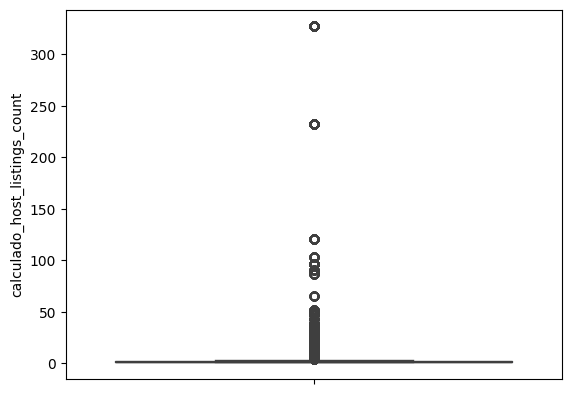

In [294]:
# Verificando outliers da coluna "calculado_host_listings_count"
sns.boxplot(df2['calculado_host_listings_count'])

<Axes: ylabel='minimo_noites'>

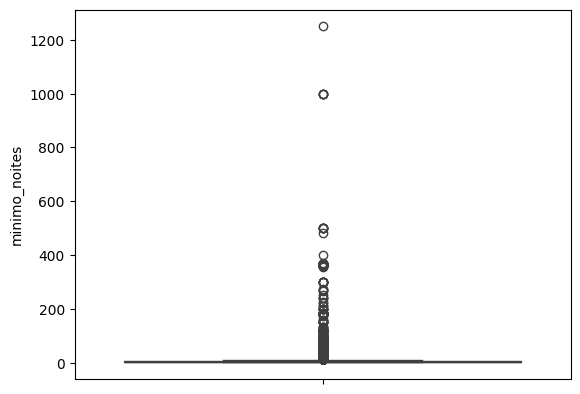

In [295]:
# Verificando outliers da coluna "minimo_noites"
sns.boxplot(df2['minimo_noites'])

## 4.2. Variáveis Categóricas 

In [296]:
df2['bairro_group'].value_counts()

bairro_group
Manhattan        21661
Brooklyn         20103
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='bairro_group'>

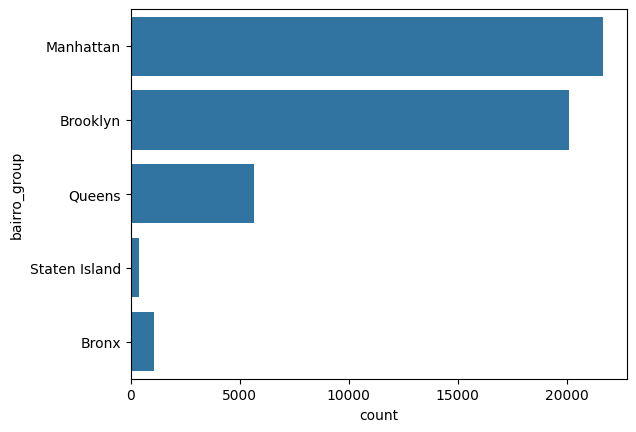

In [297]:
sns.countplot(df2['bairro_group'])

Notamos que Manhattan e Brooklyn são os distritos com mais locações. 

In [298]:
# Os 10 bairros com mais locações
df2['bairro'].value_counts().head(10)

bairro
Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
Hell's Kitchen        1958
East Village          1853
Upper East Side       1798
Crown Heights         1564
Midtown               1545
Name: count, dtype: int64

In [299]:
df2['room_type'].value_counts()

room_type
Entire home/apt    25409
Private room       22325
Shared room         1160
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='room_type'>

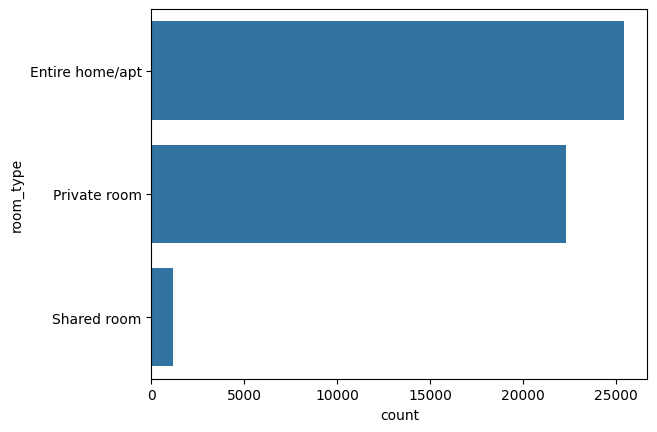

In [300]:
sns.countplot(df2['room_type'])

Vemos que a quantidade de quartos compartilhados é bem menor do que as duas outras categorias.

# 5.0 Filtragem de dados

In [301]:
df3 = df2.copy()

In [302]:
# Descartando os dados onde o preço do aluguel é igual a 0
df3 = df3[(df3['price'] != 0)] 

In [303]:
# Chamando a função para remover outliers das colunas 'minimo_noites' e 'calculado_host_listings_count'
df3 = remove_outliers_iqr(df3, ['minimo_noites', 'calculado_host_listings_count'])

In [304]:
df3[['calculado_host_listings_count','minimo_noites']].describe().T

,count,mean,std,min,25%,50%,75%,max
calculado_host_listings_count,38164.0,1.293863,0.585022,1.0,1.0,1.0,1.0,3.0
minimo_noites,38164.0,2.774657,1.873107,1.0,1.0,2.0,3.0,11.0


# 6.0. Análise Exploratória de Dados (EDA)

In [305]:
df4 = df3.copy()

## 6.1. Correlação entre as variáveis

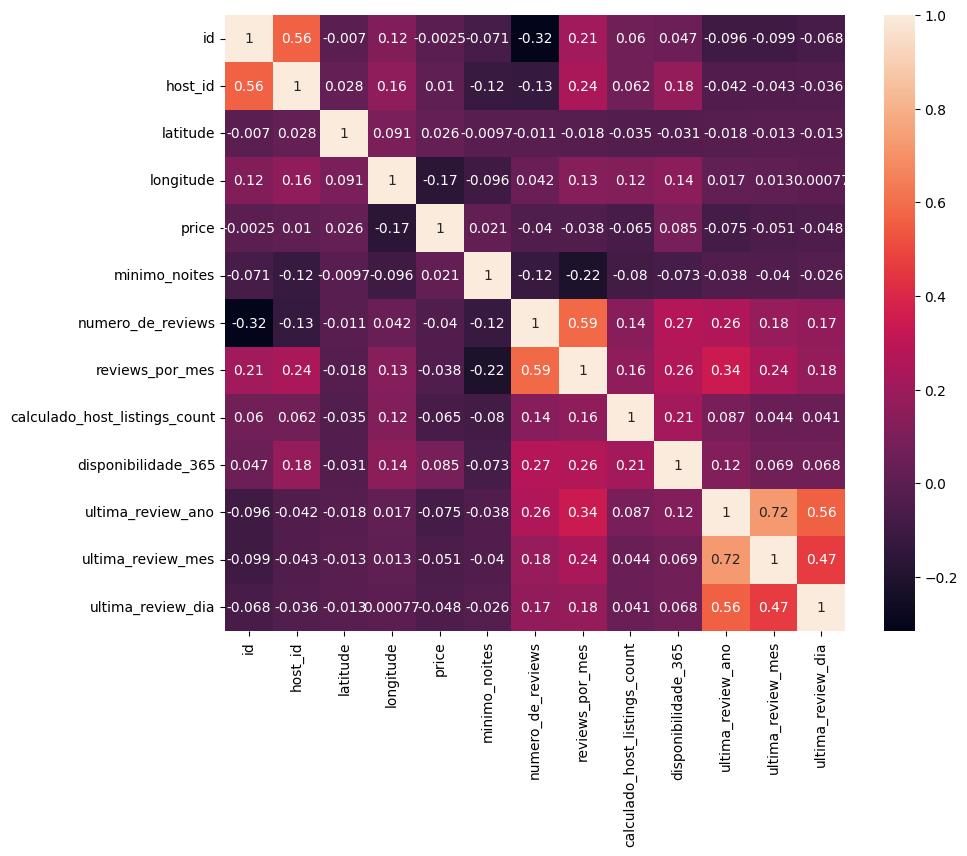

In [306]:
plt.figure(figsize=(10, 8))
correlation = df4.select_dtypes(include=('int64', 'float64')).corr( method='pearson' )
sns.heatmap( correlation, annot=True );
plt.show()

### Pelo que podemos observar não temos nenhuma correlação forte entre o preço e as outras variáveis numéricas

## 6.2. Distribuição do preço

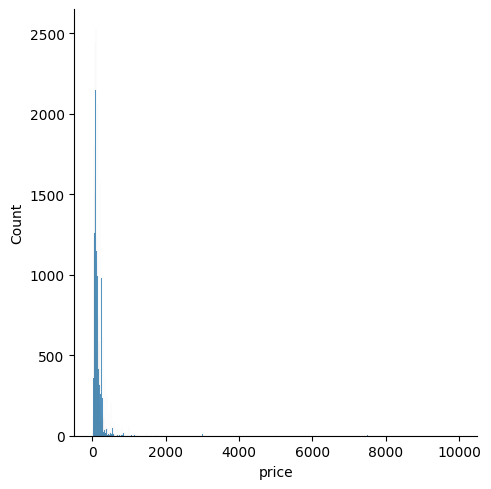

In [307]:
# Analisando a distribuição da variável preço
sns.displot(df4['price']);

### Podemos dar um zoom

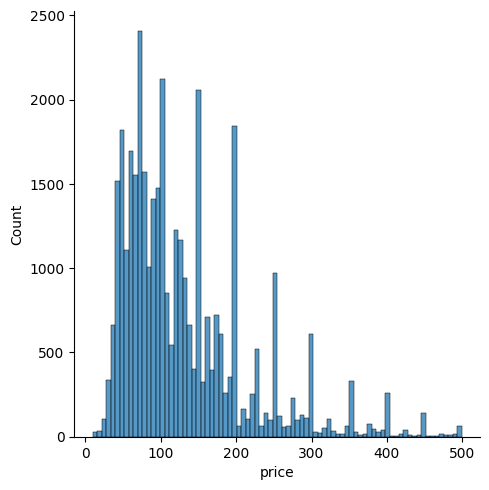

In [308]:
sns.displot(df4[df4['price'] < 500]['price']);

### Notamos que o preço se concentra em uma faixa de aproximadamente entre 100 e 200 dólares

## 6.3. Análise bivariada

### 6.3.1 Preço e bairro_group

In [309]:
df4[['price', 'bairro_group']].groupby('bairro_group').describe()

price                                                    \
                 count        mean         std   min   25%    50%    75%   
bairro_group                                                               
Bronx            853.0   90.031653  110.411736  10.0  49.0   70.0  100.0   
Brooklyn       16475.0  126.662215  171.637793  10.0  65.0   98.0  150.0   
Manhattan      16301.0  187.382553  227.586570  10.0  93.0  145.0  210.0   
Queens          4246.0  102.487753   98.037282  10.0  55.0   80.0  120.0   
Staten Island    289.0  122.259516  304.356171  13.0  57.0   80.0  115.0   

                        
                   max  
bairro_group            
Bronx           2500.0  
Brooklyn       10000.0  
Manhattan       9999.0  
Queens          2600.0  
Staten Island   5000.0

### Manhattan é o bairro mais caro de NY seguido de Brooklyn, Staten Island apesar de possuir o menor número locações, é o terceiro mais caro

### 6.3.2 Preço e bairro

In [310]:
df4[['price', 'bairro']].groupby('bairro').mean().sort_values('price', ascending=False).head(10)

,price
bairro,
Fort Wadsworth,800.000000
Woodrow,700.000000
Sea Gate,487.857143
Riverdale,477.300000
Battery Park City,462.000000
Tribeca,432.596639
Randall Manor,420.500000
Flatiron District,363.926471
Theater District,302.648148


### 6.3.3 Preço e room_type

In [311]:
df4[['price', 'room_type']].groupby('room_type').describe()

price                                                     \
                   count        mean         std   min    25%    50%    75%   
room_type                                                                     
Entire home/apt  20137.0  204.188111  233.586555  10.0  120.0  160.0  225.0   
Private room     17367.0   87.488455  110.830624  10.0   55.0   70.0   99.0   
Shared room        660.0   87.012121  126.090171  10.0   40.0   59.5   85.0   

                          
                     max  
room_type                 
Entire home/apt  10000.0  
Private room      7500.0  
Shared room       1800.0

### A média de preço de uma casa ou apartamento inteiro é bem maior do que os outros dois tipos de locações.

### 6.3.4. Preço e minimo_noites

In [312]:
df4[['price', 'minimo_noites']].groupby('minimo_noites').describe()

price                                                     \
                 count        mean         std   min   25%    50%     75%   
minimo_noites                                                               
1              10669.0  139.095417  246.137070  10.0  62.0   91.0  150.00   
2              10613.0  146.024781  146.744517  10.0  75.0  114.0  179.00   
3               7498.0  158.729528  140.134273  10.0  80.0  125.0  192.75   
4               3166.0  161.615287  151.960265  20.0  80.0  130.0  197.00   
5               2884.0  159.651526  288.910369  10.0  75.0  120.0  189.00   
6                718.0  167.392758  237.728069  30.0  80.0  120.0  198.25   
7               1922.0  145.702393  176.571009  10.0  65.0  108.0  170.00   
8                120.0  120.933333   70.566225  30.0  75.0  100.0  150.00   
9                 74.0  125.243243   76.339331  16.0  68.5  119.5  168.75   
10               469.0  135.458422  151.342613  15.0  60.0  100.0  150.00   
11                31.0  161.451613  177.806794  35.0  80.0  104.0  162.50   

                        
                   max  
minimo_noites           
1               7500.0  
2               5000.0  
3               3000.0  
4               4000.0  
5              10000.0  
6               5000.0  
7               3000.0  
8                500.0  
9                469.0  
10              1731.0  
11              1000.0

<Axes: xlabel='minimo_noites', ylabel='price'>

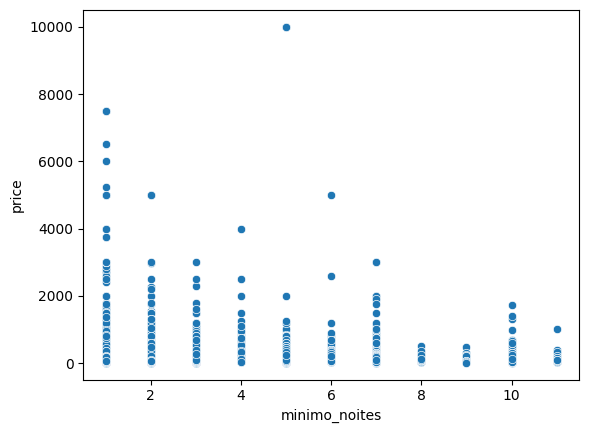

In [313]:
sns.scatterplot(x='minimo_noites', y='price', data=df4)

### No geral há preços maiores quanto menor é o mínimo de noites necessárias.

### 6.3.5. Preço e numero de reviews

<Axes: xlabel='numero_de_reviews', ylabel='price'>

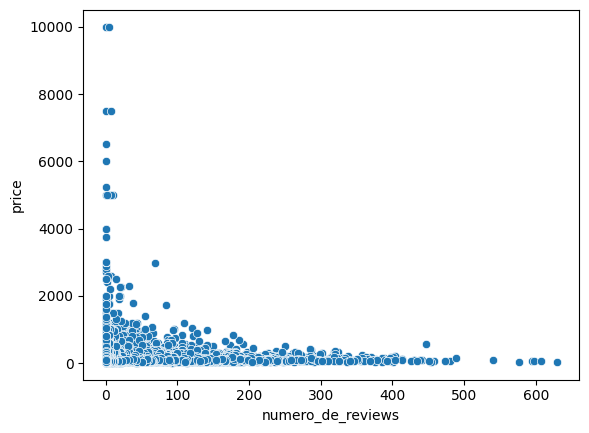

In [314]:
sns.scatterplot(x='numero_de_reviews', y='price', data=df4)

### Podemos observar que locais que receberam muitos reviews costumam ser mais baratos. O que significa que o preço baixo faz com que a demanda seja alta.

### 6.3.6. Preço e disponibilidade

<Axes: xlabel='disponibilidade_365', ylabel='price'>

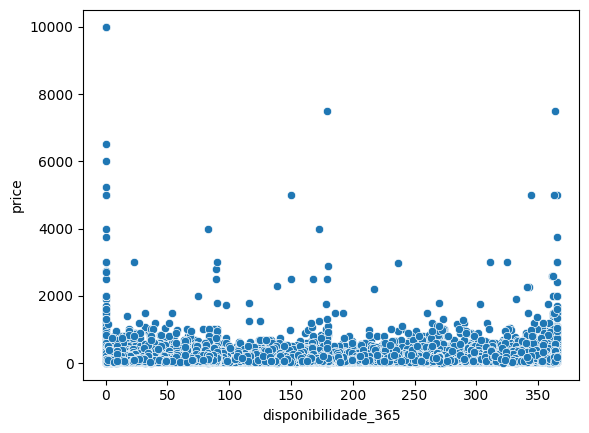

In [315]:
sns.scatterplot(x='disponibilidade_365', y='price', data=df4)

### A princípio a disponibilidade parece não afetar no preço do aluguel.

# 7.0. Perguntas a serem respondidas

## 7.1. Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?

Para escolhermos o melhor local devemos analisar qual região possui os maiores preços de aluguéis, qual tipo de locação é a melhor, e locais com maior demanda de locação

- O melhor tipo de locação seria uma casa ou apartamento inteiro, dado que possuem os maiores preços.
- A região de Manhattan parece ser o melhor por possuir a maior quantidade de imóveis(junto com Brooklin) e possuir a maior média de preço

In [316]:
# Vamos filtrar a região de Manhattan e com tipos de quarto casa e apartamento inteiros
aux = df4[(df4['bairro_group'] == 'Manhattan') & (df4['room_type'] == 'Entire home/apt')]

In [317]:
# Vamos verificar os bairros com as maiores quantidades de locações e com a melhor média de preço
result = aux[['price', 'bairro']].groupby('bairro').agg({'price': ['count', 'mean']}).sort_values(('price', 'count'), ascending=False)

In [318]:
result.head(5)

price            
                count        mean
bairro                           
East Village     1002  219.322355
Upper East Side   938  211.559701
Upper West Side   899  240.055617
Harlem            889  180.154106
Hell's Kitchen    845  254.719527

### Resp: 
Eu escolheria o bairro de Upper West Side em Manhattan, dado que possui um preço médio de 240 dólares com uma quantidade elevada de imóveis.


## 7.2.	O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

### Resp:
Pelo que analisamos pelas seções 6.1, 6.3.4 e 6.3.6, primeiramente notamos que não há correlação entre o preço e o mínimo de noites e nem com a disponibilidade ao longo do ano. A dispobilidade ao longo do ano também não parece influenciar quando observamos pelo gráfico.

O número mínimo de noites no entanto, pelo gráfico, apresenta preços menores ao longo que o mínimo aumenta.

## 7.3.	Existe algum padrão no texto do nome do local para lugares de mais alto valor?

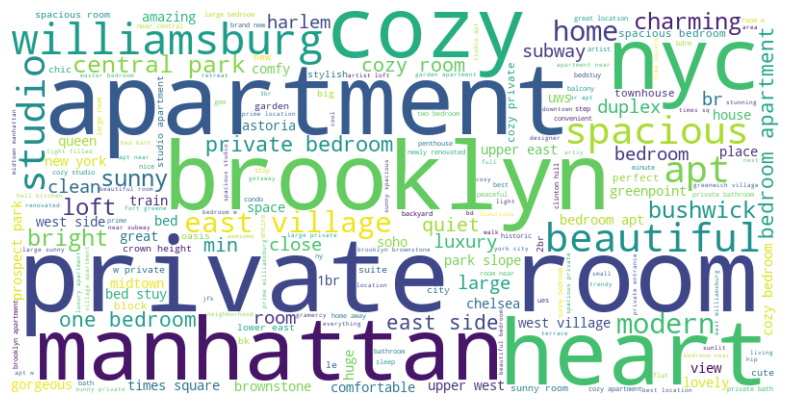

In [319]:
# Texto 
texto = ' '.join(str(n).lower() for n in df4.nome)
# Criando um objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(texto)

# Exibindo a nuvem de palavras usando matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Oculta os eixos
plt.show()

### Resp:
- Podemos notar primeiramente as palavras 'brooklyn' e 'manhatta'n que possuem a maioria das locações, após isso também se nota 'apartment' e 'private room' que também são a maioria das locações

- 'east side', 'upper east' e 'upper west' também podem ser observados em destaque 

- As palavras 'cozy' e 'heart' também possuem bastante destaque e podem ajudar a estabelecer um alto valor

# 8.0. Predição de preço

Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

### Resp:

- Nós descartaremos as colunas ('id', 'nome', 'host_id', 'host_name', 'latitude', 'longitude' e 'ultima_review') dado que essas colunas não possuem motivos para interferir no preço. OBS: a coluna 'nome' pode ser uma excessão mas devido a complexidade de se lidar com esse dado nesse momento foi deixado de fora.

- As transformações serão primeiramente das variáveis categóricas para variáveis númericas. Usaremos o One Hot Encoder pois as variáveis não possuem nenhuma ordem específica. 

- Para as variáveis númericas precisamos normalizá-las para termos uma distribuição normal. Usaremos RobustScaler

- Dado que possuímos uma variável alvo('preço') e que ela é contínua, temos assim um problema de Regressão.

- Vamos utilizar aqui os algoritmos de Regressão Linear, Random Forest, e XGboost

- As métricas utizadas serão MAPE (Mean Absolute Percentage Error), MAE (Mean Absolute Error) e RMSE (Root Mean Squared Error), pois são métricas comumente utilizadas em problemas de regressão.

In [320]:
df5 = df4.copy()

## 8.1. Feature Selection

In [321]:
df5.columns

Index(['id', 'nome', 'host_id', 'host_name', 'bairro_group', 'bairro',
       'latitude', 'longitude', 'room_type', 'price', 'minimo_noites',
       'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count',
       'disponibilidade_365', 'ultima_review_ano', 'ultima_review_mes',
       'ultima_review_dia'],
      dtype='object')

### 8.1.1. Removando variáveis

In [322]:
# Podemos remover as varíaveis id nome host_id host_name latitude longitude
df5.drop(['id', 'nome', 'host_id', 'host_name', 'latitude', 'longitude'], axis = 1, inplace=True)

### 8.1.2. Normalização

In [323]:
df6 = df5.copy()

In [324]:
aux = df6.select_dtypes(include=('int64', 'float64'))
aux.drop('price', axis=1,inplace=True)
rs = RobustScaler()
aux_scaled = rs.fit_transform(aux.values)

In [325]:
# Criando um novo DataFrame com as colunas redimensionadas
aux_scaled_df = pd.DataFrame(aux_scaled, columns=aux.columns)

In [326]:
# Adicionando as colunas redimensionadas de volta ao DataFrame original
aux_scaled_df.index = df6.index
df6[aux.columns] = aux_scaled_df

In [327]:
df6.head()

,bairro_group,bairro,room_type,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,ultima_review_ano,ultima_review_mes,ultima_review_dia
0,Manhattan,Midtown,Entire home/apt,225,-0.5,1.56,-0.023810,1.0,2.085890,0.000000,-0.2,0.428571
1,Manhattan,Harlem,Private room,150,0.5,-0.24,-0.250000,0.0,2.147239,-673.000000,-1.2,-0.571429
2,Brooklyn,Clinton Hill,Entire home/apt,89,-0.5,10.56,2.511905,0.0,1.098160,0.000000,0.2,-0.333333
3,Manhattan,East Harlem,Entire home/apt,80,4.0,0.12,-0.190476,0.0,-0.092025,-0.333333,1.0,0.333333
4,Manhattan,Murray Hill,Entire home/apt,200,0.5,2.72,0.101190,0.0,0.699387,0.000000,0.0,0.476190


### 8.1.1. Transformação de variáveis categóricas em numéricas

In [328]:
df7 = df6.copy()

In [329]:
# Utilizaremos One Hot Encoding
df7 = pd.get_dummies(df7, columns=['bairro_group', 'bairro', 'room_type'], prefix=['bairro_group', 'bairro', 'room_type'])

In [330]:
df7.loc[:, df7.dtypes == bool] = df7.loc[:, df7.dtypes == bool].astype(int)

C:\Users\jooji\AppData\Local\Temp\ipykernel_8200\3729087076.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df7.loc[:, df7.dtypes == bool] = df7.loc[:, df7.dtypes == bool].astype(int)
C:\Users\jooji\AppData\Local\Temp\ipykernel_8200\3729087076.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 1 ... 1 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df7.loc[:, df7.dtypes == bool] = df7.loc[:, df7.dtypes == bool].astype(int)
C:\Users\jooji\AppData\Local\Temp\ipykernel_8200\3729087076.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 0 ... 0 1 1]' has dtype incompatible with bool, please explicitly cast to a c

In [331]:
df7.head()

,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,ultima_review_ano,ultima_review_mes,ultima_review_dia,bairro_group_Bronx,...,bairro_Williamsburg,bairro_Willowbrook,bairro_Windsor Terrace,bairro_Woodhaven,bairro_Woodlawn,bairro_Woodrow,bairro_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,225,-0.5,1.56,-0.023810,1.0,2.085890,0.000000,-0.2,0.428571,0,...,0,0,0,0,0,0,0,1,0,0
1,150,0.5,-0.24,-0.250000,0.0,2.147239,-673.000000,-1.2,-0.571429,0,...,0,0,0,0,0,0,0,0,1,0
2,89,-0.5,10.56,2.511905,0.0,1.098160,0.000000,0.2,-0.333333,0,...,0,0,0,0,0,0,0,1,0,0
3,80,4.0,0.12,-0.190476,0.0,-0.092025,-0.333333,1.0,0.333333,0,...,0,0,0,0,0,0,0,1,0,0
4,200,0.5,2.72,0.101190,0.0,0.699387,0.000000,0.0,0.476190,0,...,0,0,0,0,0,0,0,1,0,0


## 8.2. Machine learning Modelling

In [332]:
df8 = df7.copy()

In [333]:
# Vamos separa a variável alvo com as variáveis independentes
x = df8.drop('price', axis=1)
y = df8['price']

In [334]:
# Separando os dados de treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

### 8.2.1. Regressão Linear

In [335]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
ypred_lr = lr.predict( x_test )

In [336]:
# performance
# MAE
mae_lr = mean_absolute_error(y_test, ypred_lr)

# RMSE
rmse_lr = np.sqrt(mean_squared_error(y_test, ypred_lr))

# MAPE
mape_lr = mean_absolute_percentage_error(y_test,  ypred_lr)

print("MAE:", mae_lr)
print("RMSE:", rmse_lr)
print("MAPE:", mape_lr)

MAE: 41243.594413160296
RMSE: 2203073.4237042223
MAPE: 881.7062491165225


### 8.2.2. Random Forest

In [337]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit( x_train, y_train )
# prediction
ypred_rf = rf.predict( x_test )

In [338]:
# performance
# MAE
mae_rf = mean_absolute_error(y_test, ypred_rf)

# RMSE
rmse_rf = np.sqrt(mean_squared_error(y_test, ypred_rf))

# MAPE
mape_rf = mean_absolute_percentage_error(y_test,  ypred_rf)

print("MAE:", mae_rf)
print("RMSE:", rmse_rf)
print("MAPE:", mape_rf)

MAE: 64.78257271467635
RMSE: 182.29062232084158
MAPE: 0.44995664323532847


### 8.2.3. XGBoost Regressor

In [339]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.1, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( x_train, y_train )

# prediction
ypred_xgb = model_xgb.predict( x_test )

In [340]:
# performance
# MAE
mae_xgb = mean_absolute_error(y_test, ypred_xgb)

# RMSE
rmse_xgb = np.sqrt(mean_squared_error(y_test, ypred_xgb))

# MAPE
mape_xgb = mean_absolute_percentage_error(y_test,  ypred_xgb)

print("MAE:", mae_xgb)
print("RMSE:", rmse_xgb)
print("MAPE:", mape_xgb)

MAE: 62.80213086811216
RMSE: 176.3314321377406
MAPE: 0.4334271656325528


## Pelas métricas, o de menor erro foi o XGBoost Regressor, por isso vamos utilizar esse modelo

# 9.0 Supondo um apartamento com as seguintes características:

{'id': 2595,

 'nome': 'Skylit Midtown Castle',
 
 'host_id': 2845,
 
 'host_name': 'Jennifer',
 
 'bairro_group': 'Manhattan',
 
 'bairro': 'Midtown',
 
 'latitude': 40.75362,
 
 'longitude': -73.98377,
 
 'room_type': 'Entire home/apt',
 
 'price': 225,
 
 'minimo_noites': 1,
 
 'numero_de_reviews': 45,
 
 'ultima_review': '2019-05-21',
 
 'reviews_por_mes': 0.38,
 
 'calculado_host_listings_count': 2,
 
 'disponibilidade_365': 355}
 
 Qual seria a sua sugestão de preço?

### Podemos observar que esses dados já fazem parte do nosso dataset, por isso para que não tenhamos o trabalho de transformação de dados(criação de colunas), vamos pegar esse dados direto do dataframe e prever o preço com o nosso modelo

In [341]:
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [342]:
# Vemos que já é o primeiro dado
x_novo = x.iloc[0,:]
x_novo_df = x_novo.to_frame().T

In [343]:
# prediction
ypred_xgb = model_xgb.predict(x_novo_df )
print('O preço sugerido é: ${}'.format(ypred_xgb))

O preço sugerido é: $[249.75237]


### Vemos que o preço sugerido é diferente do verdadeiro, mas podemos ver que são bem próximos.

In [344]:
# Criando o modelo pickle
# pickle.dump(model_xgb, open('C:/Users/jooji/datascience/indicium/desafio-cienciadados-2024/pkl_model/modelo_previsao.pkl', 'wb'))